In [1]:
using Pkg
pkg"activate ../../.."


In [2]:
using Embeddings

using DataDeps

In [3]:
dd_name = language_files(Embeddings.FastText_Bin{:fr}) |> last

"FastText fr Wiki Binary/wiki.fr.bin"

In [5]:
#https://github.com/facebookresearch/fastText/blob/master/src/dictionary.cc

In [6]:
stat(datadep"FastText en Wiki Binary/wiki.en.bin")

StatStruct(mode=0o100644, size=8493673445)

In [12]:
@enum EntryType::Int8 word_type=0 label_type=1

struct Entry
    word::String
    count::Int64
    entry_type:: EntryType
    subwords::Vector{Int32}
end
Entry()=Entry("", 0, word_type, Int32[])


Entry

In [14]:
const FASTTEXT_VERSION = Int32(12); # Version 1b 
const FASTTEXT_FILEFORMAT_MAGIC_INT32 = Int32(793712314);


function load_header(fh)
	### Check Model
    magic = read(fh, Int32)
    @assert magic== FASTTEXT_FILEFORMAT_MAGIC_INT32
    version = read(fh, Int32)
    version == FASTTEXT_VERSION || @debug "Unexpected FastText Version" expected=FASTTEXT_VERSION actual=version
    println()
end

function load_args(fh)
    ## Load Args https://github.com/facebookresearch/fastText/blob/master/src/args.cc#L261
    args_dim = read(fh, Int32)
    args_ws = read(fh, Int32)
    args_epoch = read(fh, Int32)
    args_minCount = read(fh, Int32)
    args_neg = read(fh, Int32)
    args_wordNgrams = read(fh, Int32)
    args_loss = read(fh, Int32)
    args_model = read(fh, Int32)
    args_bucket = read(fh, Int32)
    args_minn = read(fh, Int32)
    args_maxn = read(fh, Int32)
    args_lrUpdateRate = read(fh, Int32)
    args_t = read(fh, Float64)
    println()
end

function load_fastext_dict(fh)
    ## Load model dict, https://github.com/facebookresearch/fastText/blob/master/src/dictionary.cc#L419   
    size_ = read(fh, Int32)
    nwords = read(fh, Int32)
    nlabels = read(fh, Int32)
    ntokens = read(fh, Int64)
    pruneidx_size_ = read(fh, Int64)
    
    words_ = map(1:size_) do ii
        e_word=readuntil(fh, '\0')
        e_count=read(fh, Int64)
        e_entry_type=read(fh, EntryType)
        Entry(e_word, e_count, e_entry_type, Int32[ii]) # Assume no subwords, just self.
    end
    @assert pruneidx_size_ < 0 
    # Avoid loading this stuff https://github.com/facebookresearch/fastText/blob/master/src/dictionary.cc#L437
    words_
end

function load_matrix(fh)
    ### Load Matrix
    #https://github.com/facebookresearch/fastText/blob/master/src/matrix.cc#L114
    
    m_ = read(fh, Int64)
    n_ = read(fh, Int64)
    data = read!(fh, Array{Float32}(undef, (m_, n_))) # Note `real` is a typedef for `float32`
    data
end

function load_fasttext_bin(filename)
    local dict_, input_, output_
	open(filename) do fh
		load_header(fh) #Discard them
		load_args(fh) # Discared them
		dict_ = load_fastext_dict(fh)
		
		quant_input = read(fh, Bool)
		@assert !quant_input # avoid that stuff
		input_ = load_matrix(fh)
		
		quant_output = read(fh, Bool)
		@assert !quant_output # avoid that stuff
		output_ = load_matrix(fh)
		
        @assert(eof(fh))
	end
    dict_, input_, output_
end


dict_, input_, output_ = load_fasttext_bin(@datadep_str "FastText en Wiki Binary/wiki.en.bin")
@show size(dict_)
@show size(input_)
@show size(output_)



size(dict_) = (2519370,)
size(input_) = (4519370, 300)
size(output_) = (2519370, 300)


(2519370, 300)

In [17]:
using Embeddings: FastText_Bin

In [35]:
function Embeddings._load_embeddings(::Type{<:FastText_Bin}, embedding_file, max_vocab_size=Inf, keep_words=[])
    isempty(keep_words) || ArgumentError("keep_words argument is not supported by FastText_Bin all words are kept") 
    # TODO: If ever implement memory mapping then could use keep_words in that potentitally

    
    local dict_, input_
	open(embedding_file) do fh
		load_header(fh) #Discard them
		load_args(fh) # Discared them
		dict_ = load_fastext_dict(fh)
		
		quant_input = read(fh, Bool)
		@assert !quant_input # avoid that stuff
		input_ = load_matrix(fh)
    end
    
    max_vocab_size = min(max_vocab_size, length(dict_))
    (@view input_[1:max_vocab_size, :])' , [entry.word for entry in dict_]
end

In [38]:
using MLDataUtils

o_embedding_table = load_embeddings(FastText_Bin) 




InterruptException: InterruptException:

In [39]:
to_ind(lbl, enc=LabelEnc.NativeLabels(o_embedding_table.vocab)) = convertlabel(LabelEnc.Indices, lbl , enc)

to_ind (generic function with 2 methods)

In [47]:

foods = split("turkey chicken duck apple banana cheese sausage milk egg")
sports = split("cricket golf baseball football soccer rugby run walk swim dive")
colors = split("orange yellow blue green red")
tools = split("tape glue nails hammer saw drill")
objects = split("phone car truck record shed house castle rook")
other = split("down up danger risk reward  new old fresh stale glass stone china wood face");

words_by_class = [foods,sports,colors,tools,objects,other]
all_words = reduce(vcat, words_by_class)

embeddings = o_embedding_table.embeddings[:,to_ind(all_words)]

classes = map(all_words) do word
    findfirst(col -> word ∈ col, words_by_class)
end;

Computing t-SNE  2%|█                                   |  ETA: 0:00:04
Computing t-SNE  5%|██                                  |  ETA: 0:00:04
Computing t-SNE  6%|██                                  |  ETA: 0:00:04
Computing t-SNE  9%|███                                 |  ETA: 0:00:04
Computing t-SNE 11%|████                                |  ETA: 0:00:04
Computing t-SNE 13%|█████                               |  ETA: 0:00:04
Computing t-SNE 16%|██████                              |  ETA: 0:00:04
Computing t-SNE 18%|██████                              |  ETA: 0:00:04
Computing t-SNE 20%|███████                             |  ETA: 0:00:04
Computing t-SNE 23%|████████                            |  ETA: 0:00:03
Computing t-SNE 25%|█████████                           |  ETA: 0:00:03
Computing t-SNE 27%|██████████                          |  ETA: 0:00:03
Computing t-SNE 29%|███████████                         |  ETA: 0:00:03
Computing t-SNE 32%|████████████                        |  ETA: 

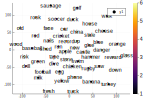

In [64]:
using Plots
using TSne
xs = tsne(embeddings', 2, 500, 2000, 20.0)'
scatter(xs[1,:], xs[2,:]; series_annotations=all_words, zcolor=classes)

# get_word_embedding
```C
void FastText::getWordVector(Vector& vec, const std::string& word) const {
  const std::vector<int32_t>& ngrams = dict_->getSubwords(word);
  vec.zero();
  for (int i = 0; i < ngrams.size(); i ++) {
    addInputVector(vec, ngrams[i]); 
  }
  if (ngrams.size() > 0) {
    vec.mul(1.0 / ngrams.size());
  }
}```

In [46]:
embeddings

52-element Array{Float32,1}:
 -0.08835874 
  0.028605528
  0.4468927  
 -0.1664481  
  0.038865376
  0.012204368
  0.047387525
  0.41482207 
  0.07806629 
  0.090056784
 -1.2282208  
  0.04789894 
 -0.45578927 
  ⋮          
 -0.04354975 
  0.36804572 
  0.64148843 
  0.22869174 
 -0.9106075  
  0.07064346 
 -0.92673564 
 -0.68822235 
 -0.09732055 
  0.13649319 
 -0.11606625 
 -0.72149366 

In [15]:
?Embeddings.EmbeddingTable

No documentation found.

`Embeddings.EmbeddingTable` is of type `UnionAll`.

# Summary

```
struct UnionAll <: Type{T}
```

# Fields

```
var  :: TypeVar
body :: Any
```

# Supertype Hierarchy

```
UnionAll <: Type{T} <: Any
```
